Sep 7th

Try the example in the main page of emcee hammer
to see the different between using and not using the log f value.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
import astropy.io.fits as fits

In [59]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [60]:
y = data['NGCs']
x = data['Mag z']
yerr = data['err GC']

In [61]:
a = np.argwhere(~np.isnan(x)) #find idx of non nan values in Mag z

In [62]:
x    = x[a]
y    = y[a]
yerr = yerr[a]

In [63]:
x    = x.reshape((len(a)))
y    = y.reshape((len(a)))
yerr = yerr.reshape((len(a)))

In [64]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Least-squares estimates:
m = -3.143 ± 0.153
b = -38.913 ± 2.576


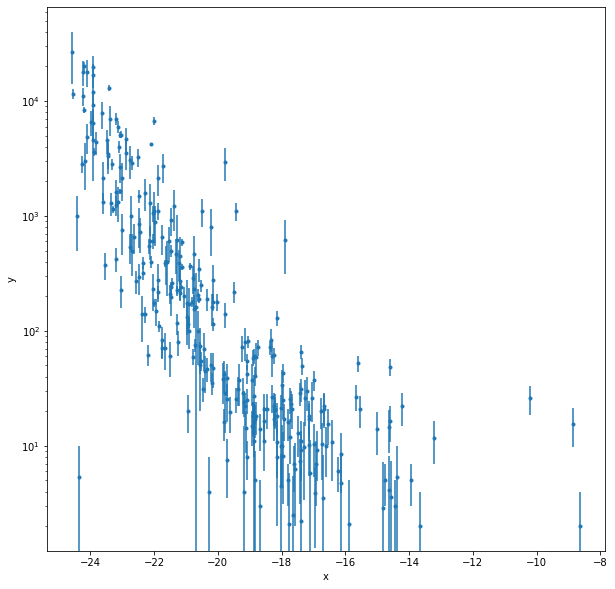

In [65]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("x")
plt.ylabel("y");

In [66]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = 10**(m * x + b)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


In [67]:
m_ini = -0.5
b_ini = -8
f_ini = 0.2

Maximum likelihood estimates:
m = -0.402
b = -5.931
f = 0.857


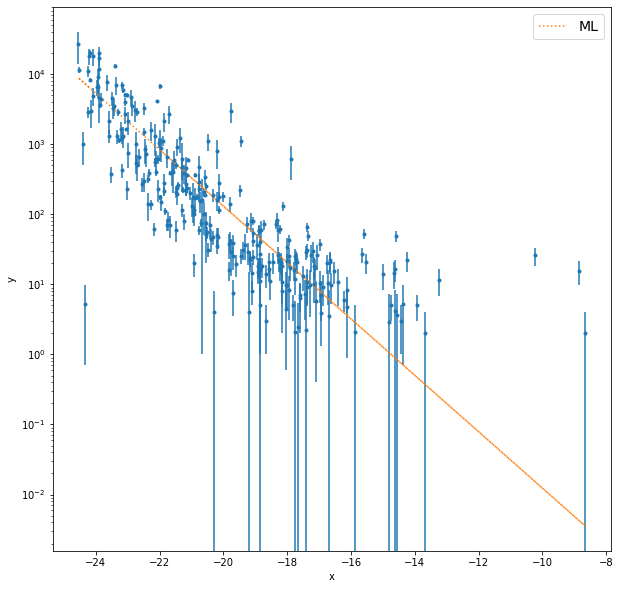

In [78]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_ini, b_ini, np.log(f_ini)]) + 1e-3 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.figure(figsize=(10,10))
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
#plt.plot(x, np.dot(np.vander(x, 2), w), "--", label="LS")
plt.plot(x, 10**np.dot(np.vander(x, 2), [m_ml, b_ml]), ":", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.yscale('log')
plt.ylabel("y");

In [69]:
def log_prior(theta):
    m, b, log_f = theta
    if -1 < m < 0. and -10 < b < 0.0 and -10.0 < log_f < 10:
        return 0.0
    return -np.inf

In [70]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [71]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

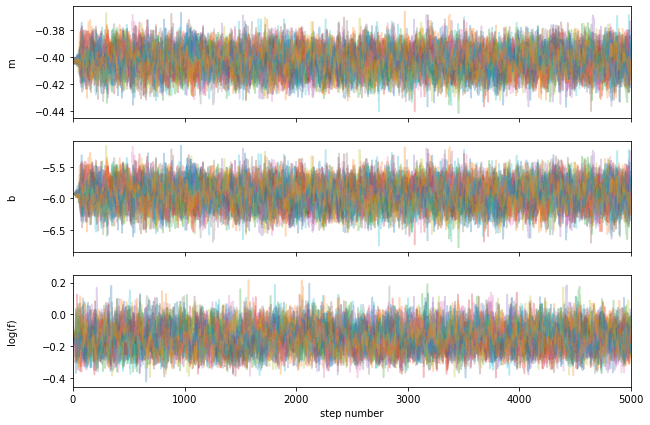

In [72]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [73]:
tau = sampler.get_autocorr_time()
print(tau)

[38.67227454 38.35305645 35.1753093 ]


In [74]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


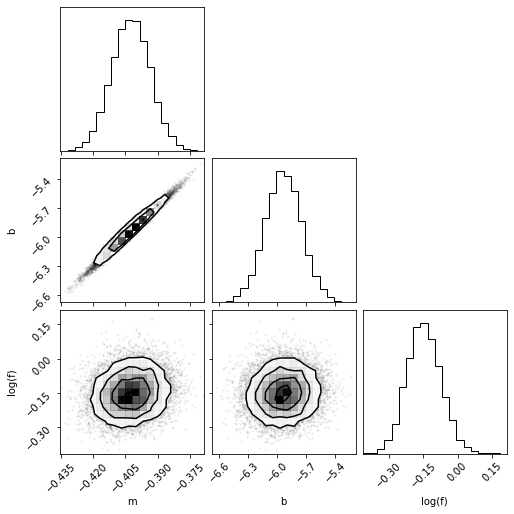

In [75]:
import corner

fig = corner.corner(flat_samples, labels=labels)

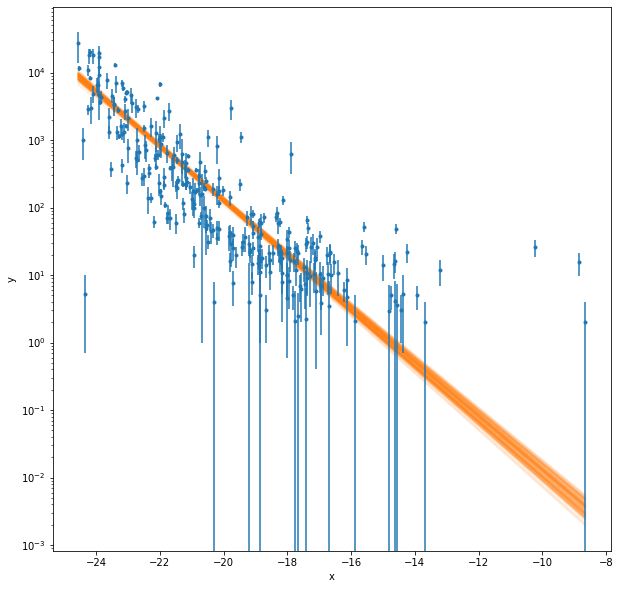

In [76]:
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize=(10,10))
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, 10**np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.yscale('log')
plt.xlabel("x")
plt.ylabel("y");


In [77]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>